# XAI Integration

## Environment Setup

In [1]:
import os
import ssl

if not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)  # GPU memory grows dynamically

print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))
print('GPU Name:', tf.config.experimental.list_physical_devices('GPU')[0])

2024-11-20 13:43:41.578807: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 13:43:41.654242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available: 1
GPU Name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Parameters

In [3]:
class_names = ['Healthy', 'Phoma', 'Cerscospora', 'Leaf rust', 'Miner']
class_names.sort()

img_size = (128, 128)
batch_size = 8

## Load test data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255)

test_gen = data_gen.flow_from_directory(
    directory='dataset_splitted/test',
    seed=42,
    class_mode='categorical',
    target_size=img_size,
    batch_size=batch_size
)

Found 874 images belonging to 5 classes.


## Model Evaluation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def evaluate_model(model) -> None:
    test_gen.reset()  # Ensure generator starts from the beginning

    true_classes, predicted_classes = [], []
    
    for _ in range(len(test_gen)):
        batch_images, batch_labels = next(test_gen)
        true_classes.extend(np.argmax(batch_labels, axis=1))
        predicted_classes.extend(np.argmax(model.predict(batch_images, verbose=0), axis=1))

    class_labels = list(test_gen.class_indices.keys())

    # Classification report
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


### CNN

In [6]:
from tensorflow.keras.models import load_model

cnn_model = load_model('models/cnn_model.keras')

2024-11-20 13:45:17.760878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12612 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


2024-11-20 13:45:21.946448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700


Classification Report:
              precision    recall  f1-score   support

 Cerscospora       0.99      0.98      0.98        99
     Healthy       1.00      1.00      1.00        99
   Leaf rust       1.00      1.00      1.00       209
       Miner       0.99      1.00      1.00       328
       Phoma       1.00      0.99      0.99       139

    accuracy                           1.00       874
   macro avg       1.00      0.99      0.99       874
weighted avg       1.00      1.00      1.00       874



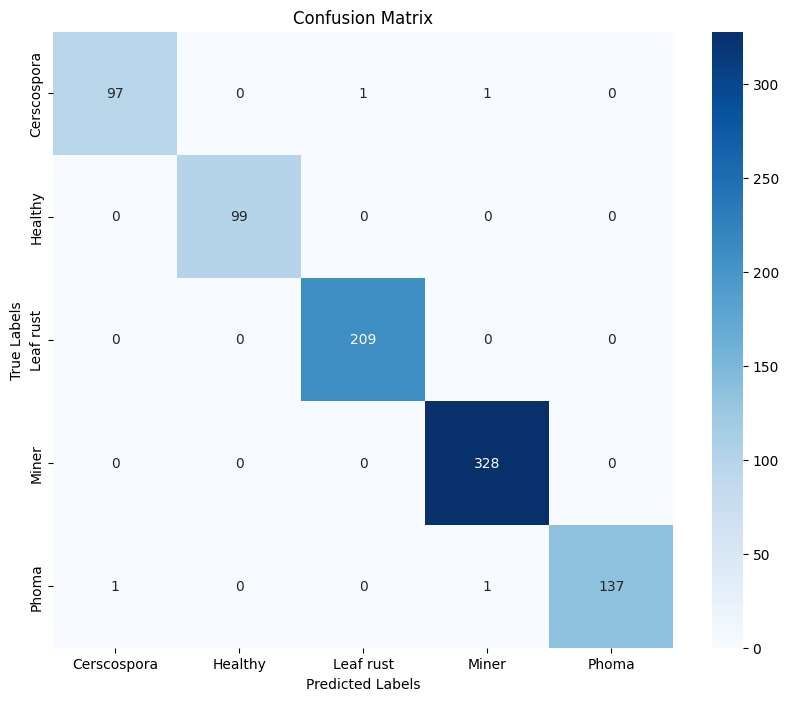

In [7]:
evaluate_model(cnn_model)

### CNN with grayscaling

In [8]:
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import register_keras_serializable


@register_keras_serializable()
class GrayscaleLayer(Layer):
    def call(self, inputs, **kwargs):
        return rgb_to_grayscale(inputs)

cnn_gray_model = load_model('models/cnn_gray_model.keras')

Classification Report:
              precision    recall  f1-score   support

 Cerscospora       0.98      0.92      0.95        99
     Healthy       0.97      0.98      0.97        99
   Leaf rust       0.98      1.00      0.99       209
       Miner       0.99      1.00      1.00       328
       Phoma       0.99      1.00      1.00       139

    accuracy                           0.99       874
   macro avg       0.98      0.98      0.98       874
weighted avg       0.99      0.99      0.99       874



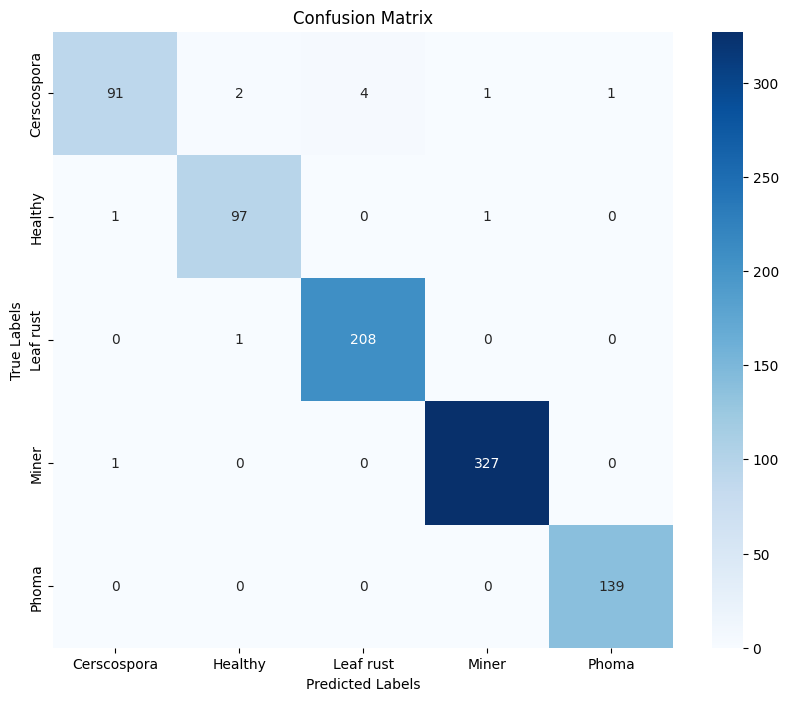

In [9]:
evaluate_model(cnn_gray_model)

### CNN with dropout

In [10]:
cnn_dropout_model = load_model('models/cnn_dropout_model.keras')

Classification Report:
              precision    recall  f1-score   support

 Cerscospora       0.99      0.98      0.98        99
     Healthy       1.00      1.00      1.00        99
   Leaf rust       1.00      1.00      1.00       209
       Miner       1.00      1.00      1.00       328
       Phoma       0.99      0.99      0.99       139

    accuracy                           1.00       874
   macro avg       0.99      0.99      0.99       874
weighted avg       1.00      1.00      1.00       874



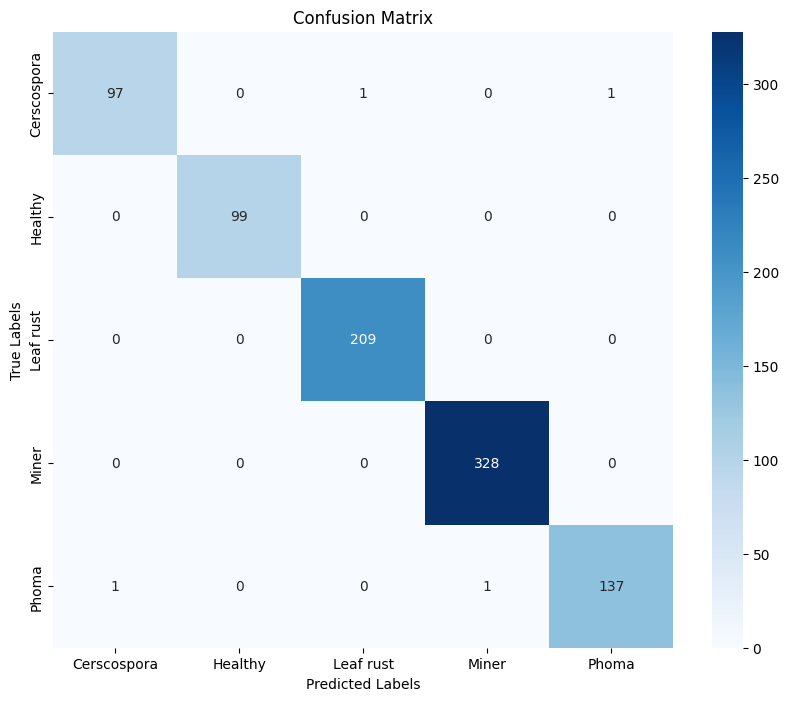

In [11]:
evaluate_model(cnn_dropout_model)

### CNN with grayscaling and dropout

In [12]:
cnn_gray_dropout_model = load_model('models/cnn_gray_dropout_model.keras')

Classification Report:
              precision    recall  f1-score   support

 Cerscospora       0.96      0.90      0.93        99
     Healthy       0.96      0.98      0.97        99
   Leaf rust       0.99      0.99      0.99       209
       Miner       0.99      0.99      0.99       328
       Phoma       0.99      0.99      0.99       139

    accuracy                           0.98       874
   macro avg       0.98      0.97      0.97       874
weighted avg       0.98      0.98      0.98       874



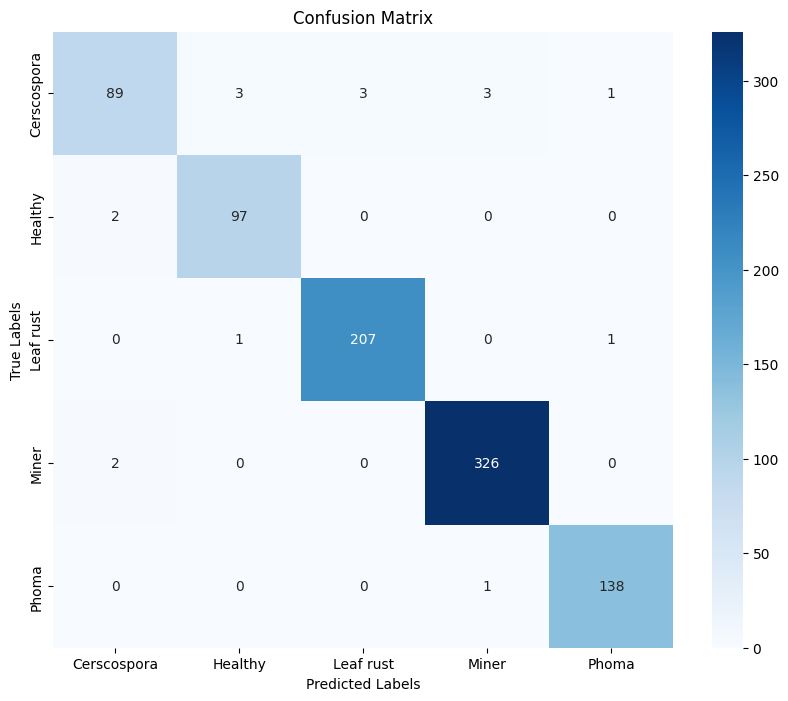

In [13]:
evaluate_model(cnn_gray_dropout_model)

### ResNet50

In [14]:
resnet50_model = load_model('models/resnet50_model.keras')

Classification Report:
              precision    recall  f1-score   support

 Cerscospora       0.00      0.00      0.00        99
     Healthy       0.00      0.00      0.00        99
   Leaf rust       0.00      0.00      0.00       209
       Miner       0.00      0.00      0.00       328
       Phoma       0.16      1.00      0.27       139

    accuracy                           0.16       874
   macro avg       0.03      0.20      0.05       874
weighted avg       0.03      0.16      0.04       874



/home/proj/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/proj/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/proj/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


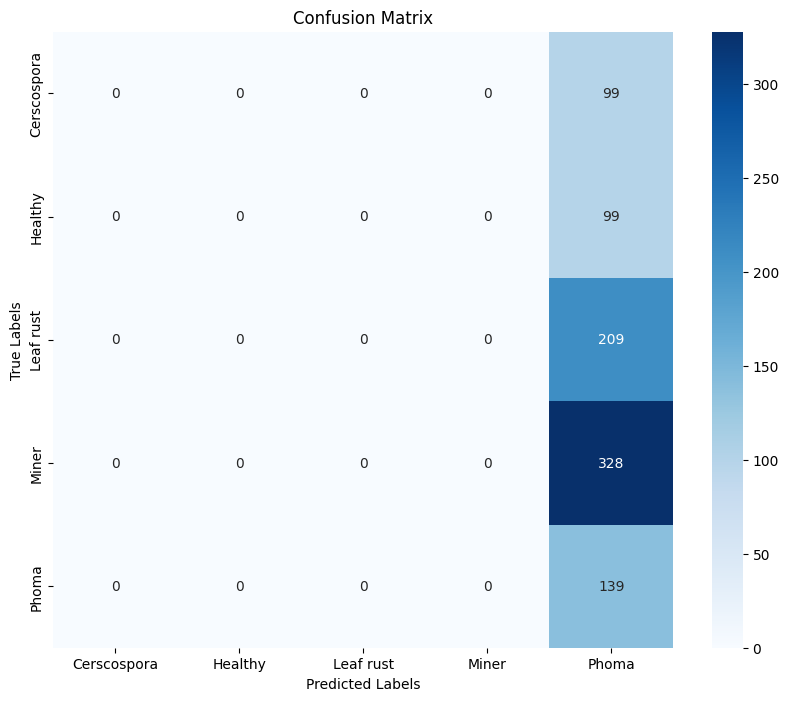

In [15]:
evaluate_model(resnet50_model)